# GROKKING

GENERALIZATION BEYOND OVERFITTING ON SMALL ALGORITHMIC DATASETSGROKKING: GENERALIZATION BEYOND OVERFITTING ON SMALL ALGORITHMIC DATASETS

- Tassilo Schallenberg: tassilo.schallenberg@gmail.com

- Michel Doroch: michel.doroch@ens-paris-saclay.fr

- Clément Tisseau: clement.tisseau@gmail.com


Testing the grokking phenomenon described in https://arxiv.org/pdf/2201.02177 using the TP1 arithmetic dataset



In [1]:
import torch
from torch import nn
from torch.nn import functional as F

import random
import math
import re
from tqdm import tqdm 
import time

import torch
import torch.nn as nn
import math
import itertools
from collections import Counter

import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings
from IPython.display import clear_output
import numpy as np

warnings.simplefilter("ignore")  


In [2]:
number_bits = 2

dataset_size = 10_240 #10_240 - 1024 #64_000
train_proportion = 0.5

log_interval = 200
batch_size = 512
epochs = 50_000
learning_rate = 8e-4

In [3]:
pad_token="[PAD]"
eos_token="[EOS]"

# Two different tokenizers

### Character-level tokenization:
Example: “12+34=46” → 1, 2, +, 3, 4, =, 4, 6

In [4]:
class character_level_tokenizer:
    """
    character-level
    """
    def __init__(self):
        self.vocab = [str(x) for x in range(10)] + ["+", "="] + [pad_token, eos_token]
        self.token_to_id = {v : k for k, v in enumerate(self.vocab)}
        self.id_to_token = {k : v for k, v in enumerate(self.vocab)}
        self.ntokens = len(self.vocab)
        self.pattern = f"[^{re.escape(''.join(self.vocab))}]"
    
    def clean(self, text):
        """
        removes all characters not in the vocabulary
        """
        out = re.sub(self.pattern, "", text)
        return out

    def pre_tokenization(self, text):
        """
        character-level
        """
        return [c for c in text]

    def encode(self, text):
        text_list = self.pre_tokenization(self.clean(text))
        return [self.token_to_id[c] for c in text_list]

    def decode(self, token_list):
        return "".join([self.id_to_token[x] for x in token_list])

### Number-level tokenization:
Example: “12+34=46” → 12, +, 34, =, 46

In [5]:
class number_level_tokenizer:

    def __init__(self, pad_token=pad_token, eos_token=eos_token):
        self.numbers = [str(x) for x in range(int('1' + '0'*number_bits))]  
        self.special_tokens = ["+", "=", pad_token, eos_token]
        self.vocab = self.numbers + self.special_tokens
        
        self.token_to_id = {v: k for k, v in enumerate(self.vocab)}
        self.id_to_token = {k: v for k, v in enumerate(self.vocab)}
        self.ntokens = len(self.vocab)

        self.pattern = re.compile(r"(\d{1,2}|[+=])")

    def clean(self, text):

        return "".join(re.findall(r"[\d+=]", text))

    def pre_tokenization(self, text):

        return self.pattern.findall(text)

    def encode(self, text):
        text_list = self.pre_tokenization(self.clean(text))
        return [self.token_to_id[c] for c in text_list]

    def decode(self, token_list):
        return "".join([self.id_to_token[x] for x in token_list])

tokenizer = number_level_tokenizer()

text = "12+34=46"
encoded = tokenizer.encode(text)
decoded = tokenizer.decode(encoded)


In [6]:
tokenizer = number_level_tokenizer()
ntokens = tokenizer.ntokens
ntokens

104

In [7]:
prompt = "12 + 42 ="
inputs = tokenizer.encode(prompt)
inputs, tokenizer.decode(inputs)

([12, 100, 42, 101], '12+42=')

## Let’s create two dataset functions. 

The first one generates a random pair of x and y along with the result of their addition (the original dataset provided in the TP). 

Similarly to the paper, we use the remainder of the sum divided by the prime number 97 as the result

In [11]:
p = 97

def sample_datapoint(number_bits = 3, remove_first_zero = True):
    """
    returns a string containing two random numbers on `number_bits` many bits and their sum.
    """
    a_list = [random.randint(0, 9) for _ in range(number_bits)]
    b_list = [random.randint(0, 9) for _ in range(number_bits)]
    
    a_str = "".join([str(x) for x in a_list])
    
    b_str = "".join([str(x) for x in b_list])
    
    if remove_first_zero:
        if a_str[0] == "0":
            a_str = "1" + a_str[1:]

        if b_str[0] == "0":
            b_str = "1" + b_str[1:]
        
    a_int = int(a_str)
    b_int = int(b_str)
    sum_int = (a_int + b_int) % p
    return (str(a_int) + "+" + str(b_int) + "=", str(sum_int))

sample_datapoint(3)

('511+153=', '82')

In [12]:
data = []
for _ in range(dataset_size):
    data.append(sample_datapoint(number_bits, remove_first_zero = False))
data[:4]

[('92+48=', '43'), ('76+29=', '8'), ('56+86=', '45'), ('62+24=', '86')]

## generate all possible combinations (x, y)

The second one generates all possible pairs of numbers within the range ($[0, 10^{(\text{number_bits})})]$) (implemented similarly to the paper). During the experiments, we will test both approaches.

In [13]:
def generate_all_datapoints(number_bits=3):


    min_val = 10**(number_bits - 1) 
    max_val = 10**number_bits - 1 
    dataset = []
    
    for a, b in itertools.product(range(min_val, max_val + 1), repeat=2):
        sum_int = (a + b) % p
        dataset.append((f"{a}+{b}=", str(sum_int)))
    
    return dataset

data = generate_all_datapoints(number_bits)

## Fill data_test to match data_train shape 

In [14]:
data_train = data[: int(train_proportion * dataset_size)]
data_test = data[int(train_proportion * dataset_size):]


while len(data_test) < len(data_train):
    data_test.append(data_test[len(data_test) % len(data_test)])
    
    
len(data_train),len(data_test)

(5120, 5120)

# Construct a model

### Positional Embedding

In [15]:
class PositionalEmbedding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens in the sequence.
        The positional encodings have the same dimension as the embeddings, so that the two can be summed.
        Here, we use sine and cosine functions of different frequencies.
    .. math:
        \text{PosEmbedder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEmbedder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        """

        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

## Transformer model 

In [16]:
class TransformerModel(nn.Transformer):
    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__(d_model=ninp,
                                               nhead=nhead,
                                               dim_feedforward=nhid,
                                               num_encoder_layers=nlayers)
        self.input_emb = nn.Embedding(ntoken, ninp)
        self.pos_encoder = PositionalEmbedding(ninp, dropout)
        
        # self.pos_encoder = RoPE(ninp)
        self.decoder = nn.Linear(ninp, ntoken)

        self.ninp = ninp
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.input_emb.weight, -initrange, initrange)
        nn.init.zeros_(self.decoder.bias)
        nn.init.uniform_(self.decoder.weight, -initrange, initrange)

    def _generate_square_subsequent_mask(self, sz):
        return torch.log(torch.tril(torch.ones(sz,sz)))

    def forward(self, src):
        mask = self._generate_square_subsequent_mask(len(src)).to(device)
        self.src_mask = mask

        src = self.input_emb(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output_enc = self.encoder(src, mask=self.src_mask)
        output_dec = self.decoder(output_enc)
        return F.log_softmax(output_dec, dim=-1), output_enc

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [18]:
model = TransformerModel(ntoken = ntokens,
                         ninp = 128,
                         nhead = 4,
                         nhid = 128*4,
                         nlayers = 2,
                         dropout=0)
model.to(device)

TransformerModel(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): Linear(in_features=128, out_features=104, bias=True)
  (input_emb): Embedding(104, 128)
  (pos_encoder): PositionalEmbedding(
    (dropout): Dropout(p=0, inplace=False)
  )
)

## Removing dropout from the network. Our goal is overfitting on the train data.

In [19]:
def remove_dropout(module):
    for name, child in module.named_children():
        if isinstance(child, nn.Dropout):

            setattr(module, name, nn.Identity())
        else:

            remove_dropout(child)

remove_dropout(model)

print(model)

TransformerModel(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Identity()
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Identity()
        (dropout2): Identity()
      )
    )
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): Linear(in_features=128, out_features=104, bias=True)
  (input_emb): Embedding(104, 128)
  (pos_encoder): PositionalEmbedding(
    (dropout): Identity()
  )
)


In [20]:
def generate(model, prompts, new_tokens = 5):
    input_tensor = prompts # (length_prompts, batch_size)
    input_tensor = input_tensor.to(device)
    for _ in range(new_tokens):
        output, _ = model(input_tensor) # (length_prompts, batch_size, ntokens)
        last_output = output[-1,:,:] # (batch_size, ntokens)
        token = torch.argmax(last_output, -1).view((1,-1)) # (1, batch_size)
        input_tensor = torch.cat((input_tensor, token), 0)
    return input_tensor

In [21]:
model.eval()

prompt = "2+3="
prompt_tensor = torch.tensor(tokenizer.encode(prompt)).view((-1,1))
output = generate(model, prompt_tensor).view((1,-1))
output, tokenizer.decode(output.tolist()[0])

(tensor([[  2, 100,   3, 101,  29,  29,  29,  86,  29]], device='cuda:0'),
 '2+3=2929298629')

In [22]:
def pad(token_list, type_list = "prompts"):
    max_length = max([len(x) for x in token_list])
    out = []
    for x in token_list:
        if type_list == "prompts":
            out.append([tokenizer.token_to_id[pad_token]] * (max_length - len(x)) + x)
        if type_list == "answers":
            out.append(x + [tokenizer.token_to_id[eos_token]] + [tokenizer.token_to_id[pad_token]] * (max_length - len(x)))
    return out, max_length

In [23]:
prompts = [tokenizer.encode("1+1="), tokenizer.encode("21+35=")]
answers = [tokenizer.encode("2"), tokenizer.encode("56")]
padded_prompts, _ = pad(prompts, "prompts")
padded_answers, _ = pad(answers, "answers")
padded_prompts, padded_answers
[tokenizer.decode(p) for p in padded_prompts], [tokenizer.decode(p) for p in padded_answers]

(['1+1=', '21+35='], ['2[EOS]', '56[EOS]'])

In [24]:
def get_batch(split, i):
    data = data_train if split == 'train' else data_test
    prompts = [tokenizer.encode(data[i][0]) for i in range(i, i + batch_size)]
    padded_prompts, length_prompts = pad(prompts, "prompts")
    answers = [tokenizer.encode(data[i][1]) for i in range(i, i + batch_size)]
    padded_answers, length_answers = pad(answers, "answers")
    X = torch.stack([torch.tensor(x) for x in padded_prompts], 1)
    Y = torch.stack([torch.tensor(x) for x in padded_answers], 1)
    return X, Y, length_prompts, length_answers

In [25]:
X, Y, length_prompts, length_answers = get_batch("train", 243)
X.shape, Y.shape, length_prompts, length_answers

(torch.Size([4, 512]), torch.Size([2, 512]), 4, 1)

## Validation. Test data

In [26]:
def evaluate():

    model.eval()
    correct = 0.
    with torch.no_grad():
        for batch, i in enumerate(range(0, len(data_test) - 1, batch_size)):
            prompts, target_answers, length_prompts, length_answers = get_batch("test", i)
            prompts = prompts.to(device) # (length_prompts, batch_size)
            target_answers = target_answers.to(device) # (length_answers + 1, batch_size)
            output = generate(model, prompts, length_answers + 1) # (length_prompts + length_answers + 1, batch_size)
            answers_tokens = output[length_prompts:, :] # (length_answers + 1, batch_size), contains tokens
            equality_test = answers_tokens == target_answers # (length_answers + 1, batch_size), contains boolean values
            correct += torch.all(equality_test, axis=0).float().sum()
        accuracy = correct / len(data_test)
    return accuracy.item()

## Validation. Training data

In [27]:
def evaluate_train():

    model.eval()
    correct = 0.
    with torch.no_grad():
        for batch, i in enumerate(range(0, len(data_train) - 1, batch_size)):
            prompts, target_answers, length_prompts, length_answers = get_batch("train", i)
            prompts = prompts.to(device) # (length_prompts, batch_size)
            target_answers = target_answers.to(device) # (length_answers + 1, batch_size)
            output = generate(model, prompts, length_answers + 1) # (length_prompts + length_answers + 1, batch_size)
            answers_tokens = output[length_prompts:, :] # (length_answers + 1, batch_size), contains tokens
            equality_train = answers_tokens == target_answers # (length_answers + 1, batch_size), contains boolean values
            correct += torch.all(equality_train, axis=0).float().sum()
        accuracy = correct / len(data_train)
    return accuracy.item()

In [28]:
len(data_train), len(data_test)

(5120, 5120)

In [29]:
evaluate()

0.0

## Plot accuracy curve

In [30]:


def plot_accuracy(train_acc, test_acc, step_size = 450):
    steps = list(range(len(train_acc)))

    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 6)) 

    plt.xscale("log") 
    
    sns.lineplot(x=steps, y=train_acc, label="Train Accuracy", color="blue", linewidth=2)
    sns.lineplot(x=steps, y=test_acc, label="Test Accuracy", color="red", linewidth=2, linestyle="--")

    plt.title("Training vs Testing Accuracy", fontsize=14)
    plt.xlabel("Number of Steps", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.ylim(0, 1) 
    
    num_ticks = 5

    xticks_positions = np.geomspace(1, len(steps), num=num_ticks, dtype=int)  
    plt.xticks(xticks_positions, [f"{x * step_size}" for x in xticks_positions]) 
    
    plt.legend()

    plt.show()


## Train loop

In [59]:
def train_epoch():
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, betas = (0.9, 0.98))
    total_loss = 0.
    start_time = time.time()
    for batch, i in enumerate(range(0, len(data_train) - 1, batch_size)):
        prompts, target_answers, length_prompts, length_answers = get_batch("train", i)
        prompts = prompts.to(device) # (length_prompts, batch_size)
        target_answers = target_answers.to(device) # (length_answers, batch_size)
        input_tensor = torch.cat((prompts, target_answers), 0) # (length_prompts + length_answers, batch_size)
        model.zero_grad()
        output, _ = model(input_tensor) # (length_prompts + length_answers, batch_size, ntokens)
        output_answers = output[length_prompts-1:-1,:,:].reshape(-1, ntokens) # (length_answers * batch_size, ntokens)
        target_answers = target_answers.view(-1)
        loss = F.cross_entropy(output_answers, target_answers)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| {:5d}/{:5d} batches | ms/batch {:5.2f} | loss {:5.2f} | perplexity {:8.2f}'.format(batch, len(data_train) // batch_size,
                                                                                                        elapsed * 1000 / log_interval, cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

def train(early_stopping = 20000):
    best_test_accuracy = None
    test_accuracy = evaluate()
    print('-' * 89)
    print('| initialisation | test accuracy {:5.2f}'.format(test_accuracy))
    print('-' * 89)
    
    steps = 0
    train_acc, test_acc = [], []
    for epoch in tqdm(range(1, epochs+1)):
        epoch_start_time = time.time()
        train_epoch()
        
        step_size = (len(data_train)/batch_size)
        steps += step_size
        
        if steps >= early_stopping:
            break
        
        if epoch % 10 == 0:
            test_accuracy = evaluate()
            train_accuracy = evaluate_train()
            
            
            train_acc.append(train_accuracy)
            test_acc.append(test_accuracy)
            
            clear_output()
            plot_accuracy(train_acc, test_acc, step_size = 10*step_size)
            

# Experiments

Achieving the phenomenon of grokking is not easy. We conducted a series of experiments with varying number of digit, two different tokenizers, two data generation strategies, and sample sizes

In [47]:
number_bits = 2
dataset_size = 10_240

 ## <span style="color:red">Exp. 1</span> 

- 2 digits (numbers contain only two digits)
- Data sampling
- Number-level tokenizer
- dataset_size = 1024

In [49]:
dataset_size = 10_24

tokenizer = number_level_tokenizer()
ntokens = tokenizer.ntokens

print(ntokens)

data = []
for _ in range(dataset_size):
    data.append(sample_datapoint(number_bits, remove_first_zero = False))
data[:4]


data_train = data[: int(train_proportion * dataset_size)]
data_test = data[int(train_proportion * dataset_size):]


104


## <span style="color:red">❌ Failure</span> 

## The model quickly overfits (achieves accuracy = 1 on the training set), but the metric on the test set does not change

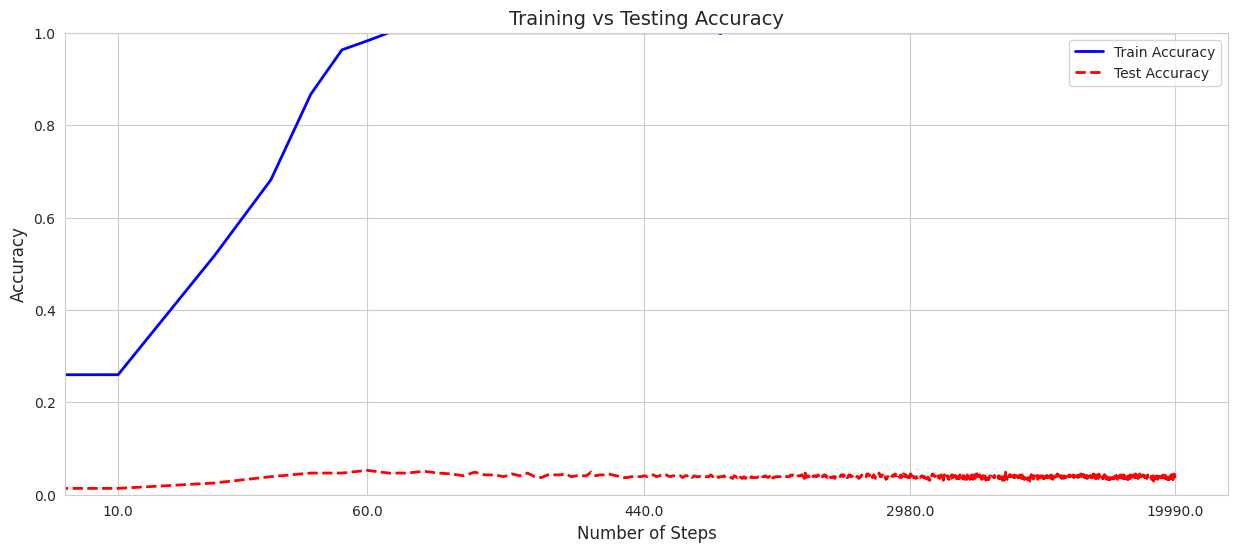

 40%|███▉      | 19999/50000 [24:48<37:12, 13.44it/s]


In [50]:
model = TransformerModel(ntoken = ntokens,
                         ninp = 128,
                         nhead = 4,
                         nhid = 128*4,
                         nlayers = 2,
                         dropout=0)
model.to(device)

remove_dropout(model)

train()

## <span style="color:red">Exp. 2</span> 

- 2 digits (numbers contain only two digits)
- Data sampling
- Digit-level tokenizer
- dataset_size = 10240

In [33]:
number_bits = 2


tokenizer = character_level_tokenizer()
ntokens = tokenizer.ntokens

print(ntokens)

data = []
for _ in range(dataset_size):
    data.append(sample_datapoint(number_bits, remove_first_zero = False))


data_train = data[: int(train_proportion * dataset_size)]
data_test = data[int(train_proportion * dataset_size):]

14


## <span style="color:red">❌ Failure</span> 

## The task is quite simple, and the model has enough data to generalize right away on the test set. The metric graph on the test set follows closely alongside the graph on the training set

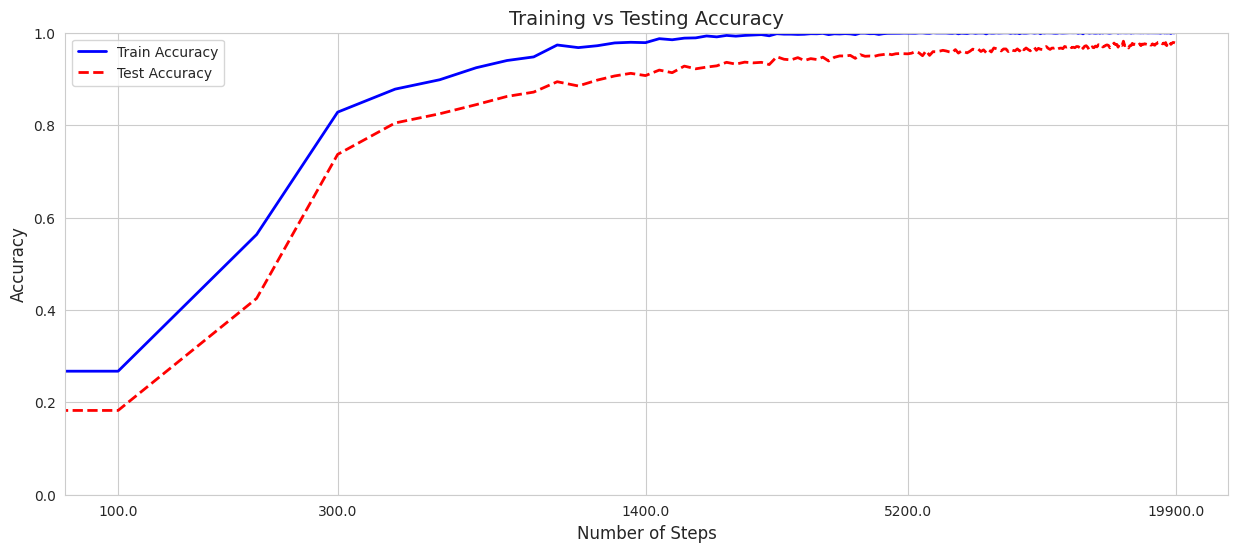

  4%|▍         | 1999/50000 [08:15<3:18:18,  4.03it/s]


In [34]:
model = TransformerModel(ntoken = ntokens,
                         ninp = 128,
                         nhead = 4,
                         nhid = 128*4,
                         nlayers = 2,
                         dropout=0)
model.to(device)

remove_dropout(model)

train()


## <span style="color:green">Exp. 3</span> 

- 2 digits (numbers contain only two digits)
- Data sampling
- Number-level tokenizer
- dataset_size = 10240

In [35]:

tokenizer = number_level_tokenizer()
ntokens = tokenizer.ntokens

print(ntokens)

data = []
for _ in range(dataset_size):
    data.append(sample_datapoint(number_bits, remove_first_zero = False))
data[:4]


data_train = data[: int(train_proportion * dataset_size)]
data_test = data[int(train_proportion * dataset_size):]



104


## <span style="color:green">✅ Success</span>

## The most striking example of grokking we obtained. After 5000 gradient steps, the metric sharply increases on the test set, although it changed very slowly until 5000 and plateaued. At the same time, the accuracy on the training data reached 1 starting from step 1000The most striking example of grokking we obtained. After 5000 gradient steps, the metric sharply increases on the test set, although it changed very slowly until 5000 and plateaued. At the same time, the accuracy on the training data reached 1 starting from step 1000

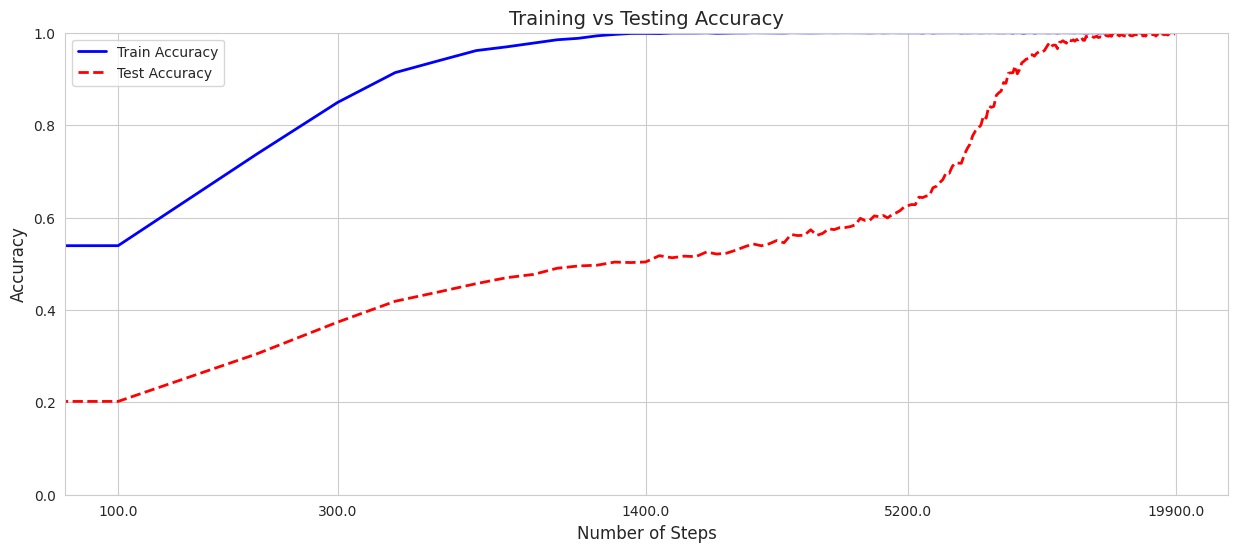

  4%|▍         | 1999/50000 [08:02<3:13:01,  4.14it/s]


In [36]:
model = TransformerModel(ntoken = ntokens,
                         ninp = 128,
                         nhead = 4,
                         nhid = 128*4,
                         nlayers = 2,
                         dropout=0)
model.to(device)

remove_dropout(model)

train()

## <span style="color:green">Exp. 4</span> 

- 2 digits (numbers contain only two digits)
- All possible pairs of x and yAll possible pairs of x and y
- Number-level tokenizer
- dataset_size = 10240

In [37]:
tokenizer = number_level_tokenizer()
ntokens = tokenizer.ntokens

print(ntokens)

data = generate_all_datapoints(number_bits = 2)

data = random.sample(data, len(data))

data_train = data[: int(train_proportion * dataset_size)]
data_test = data[int(train_proportion * dataset_size):]


while len(data_test) < len(data_train):
    missing = len(data_train) - len(data_test)
    data_test.extend(data_test[:missing]) 
    
len(data_train), len(data_test)

104


(5120, 5120)

## <span style="color:green">✅ Success</span>

## Similarly to the previous experiment, the model achieves a better score on data_test, but does so more smoothl

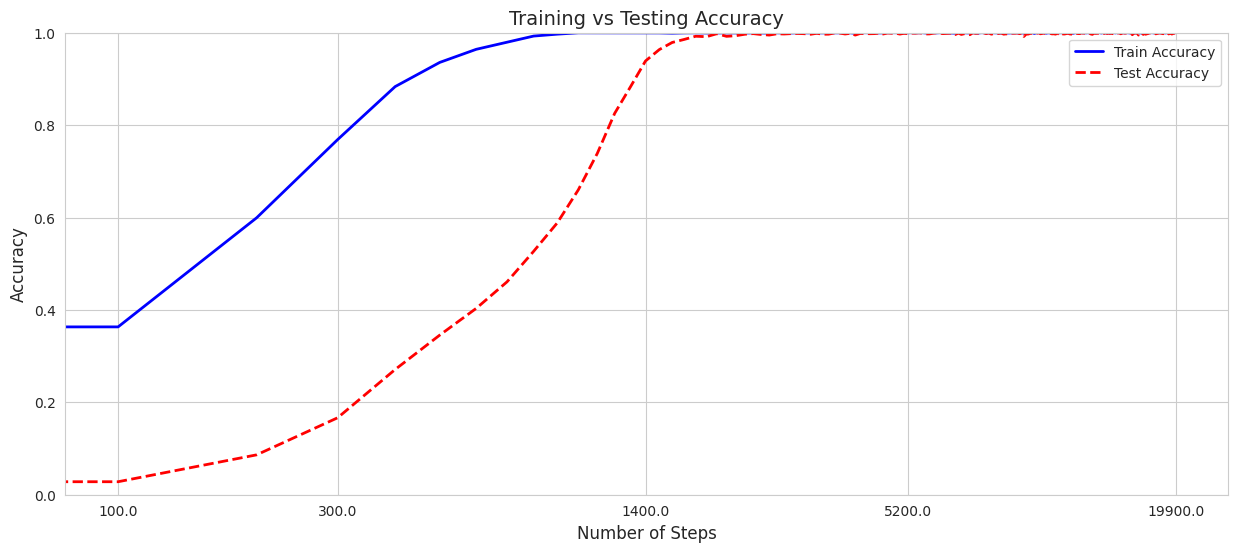

  4%|▍         | 1999/50000 [08:09<3:15:56,  4.08it/s]


In [38]:
model = TransformerModel(ntoken = ntokens,
                         ninp = 128,
                         nhead = 4,
                         nhid = 128*4,
                         nlayers = 2,
                         dropout=0)
model.to(device)

remove_dropout(model)

train()

In [39]:
# train()

----

# Three digits:

## <span style="color:red">Exp. 5</span> 

- 3 digits (numbers contain only three digits)
- Data sampling
- Digit-level tokenizer
- dataset_size = 10240

In [41]:
number_bits = 3

tokenizer = character_level_tokenizer()
ntokens = tokenizer.ntokens

print(ntokens)

data = []
for _ in range(dataset_size):
    data.append(sample_datapoint(number_bits, remove_first_zero = False))
data[:4]


data_train = data[: int(train_proportion * dataset_size)]
data_test = data[int(train_proportion * dataset_size):]

14


## <span style="color:red">❌ Failure</span> 

## The model reaches accuracy = 1 on the training data, but it took more epochs compared to the 2-digit case. During all 20,000 gradient steps, the metric on the test set remains unchanged

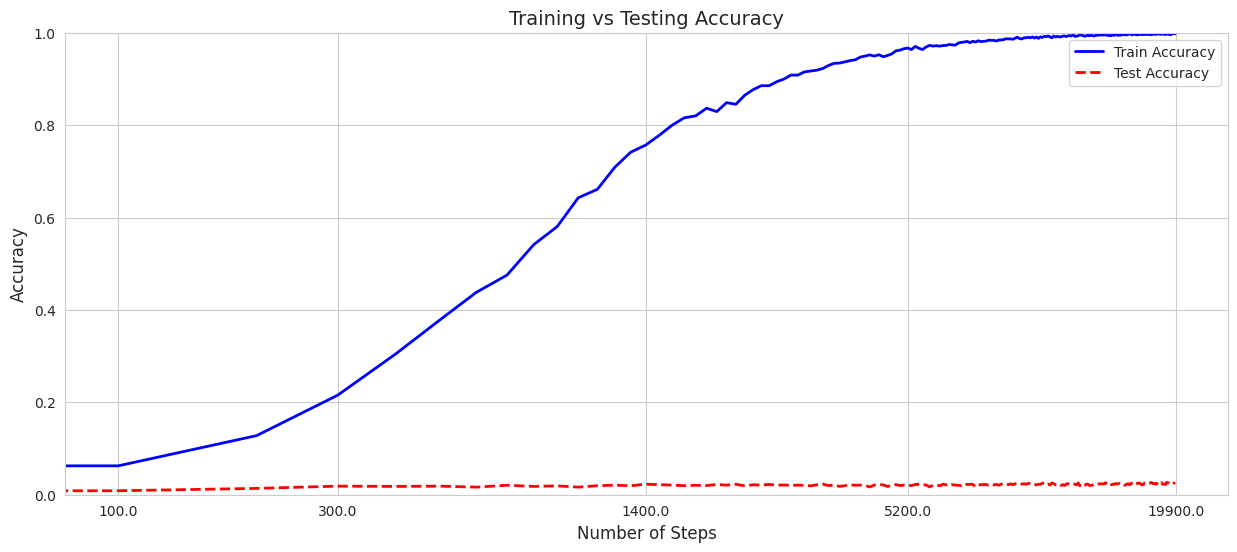

  4%|▍         | 1999/50000 [08:50<3:32:11,  3.77it/s]


In [42]:
model = TransformerModel(ntoken = ntokens,
                         ninp = 128,
                         nhead = 4,
                         nhid = 128*4,
                         nlayers = 2,
                         dropout=0)
model.to(device)

remove_dropout(model)

train()

## <span style="color:red">Exp. 6</span> 

- 3 digits (numbers contain only three digits)
- Data sampling
- Number-level tokenizer
- dataset_size = 10240

In [43]:
number_bits = 3

tokenizer = number_level_tokenizer()
ntokens = tokenizer.ntokens

print(ntokens)

data = []
for _ in range(dataset_size):
    data.append(sample_datapoint(number_bits, remove_first_zero = False))
data[:4]


data_train = data[: int(train_proportion * dataset_size)]
data_test = data[int(train_proportion * dataset_size):]

1004


## <span style="color:red">❌ Failure</span> 

## Similarly to the previous point: the model reaches accuracy = 1 on the training data, but it took more epochs compared to the 2-digit case. During all 20,000 gradient steps, the metric on the test set remains unchanged

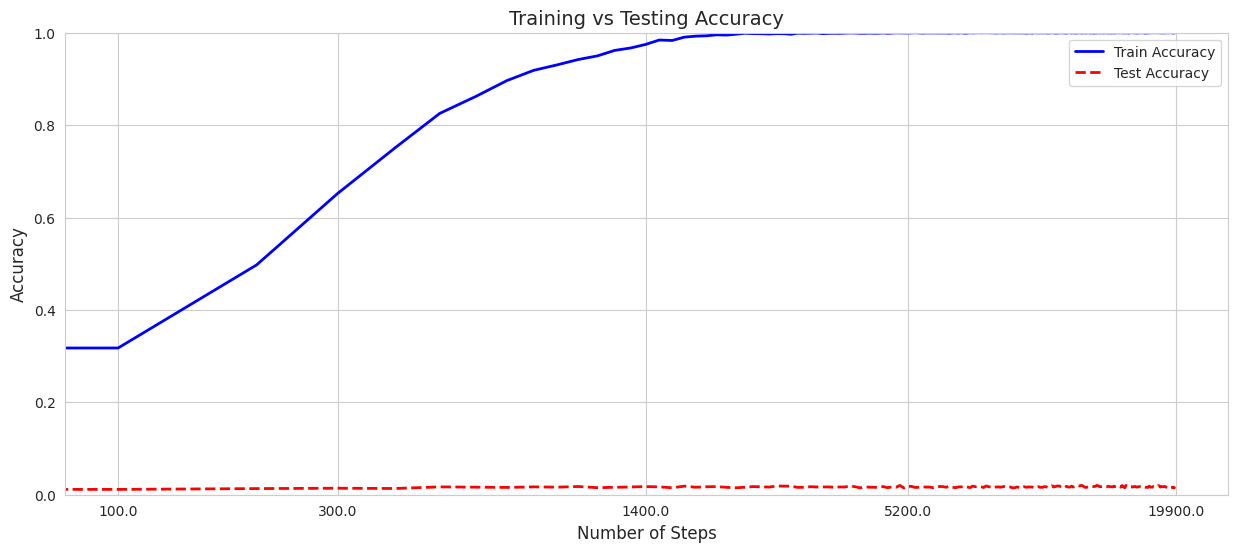

  4%|▍         | 1999/50000 [08:53<3:33:32,  3.75it/s]


In [44]:
model = TransformerModel(ntoken = ntokens,
                         ninp = 128,
                         nhead = 4,
                         nhid = 128*4,
                         nlayers = 2,
                         dropout=0)
model.to(device)

remove_dropout(model)

train()

## <span style="color:red">Exp. 7</span> 

- 3 digits (numbers contain only three digits)
- Data sampling
- Number-level tokenizer
- dataset_size = 102400

In [45]:
number_bits = 3

dataset_size *= 10

tokenizer = number_level_tokenizer()
ntokens = tokenizer.ntokens

print(ntokens)

data = []
for _ in range(dataset_size):
    data.append(sample_datapoint(number_bits, remove_first_zero = False))
data[:4]


data_train = data[: int(train_proportion * dataset_size)]
data_test = data[int(train_proportion * dataset_size):]

1004


## <span style="color:red">❌ Failure</span> 

Increasing the data by 10 times resulted in the metric on the test set closely matching the metric on the training set throughout all steps

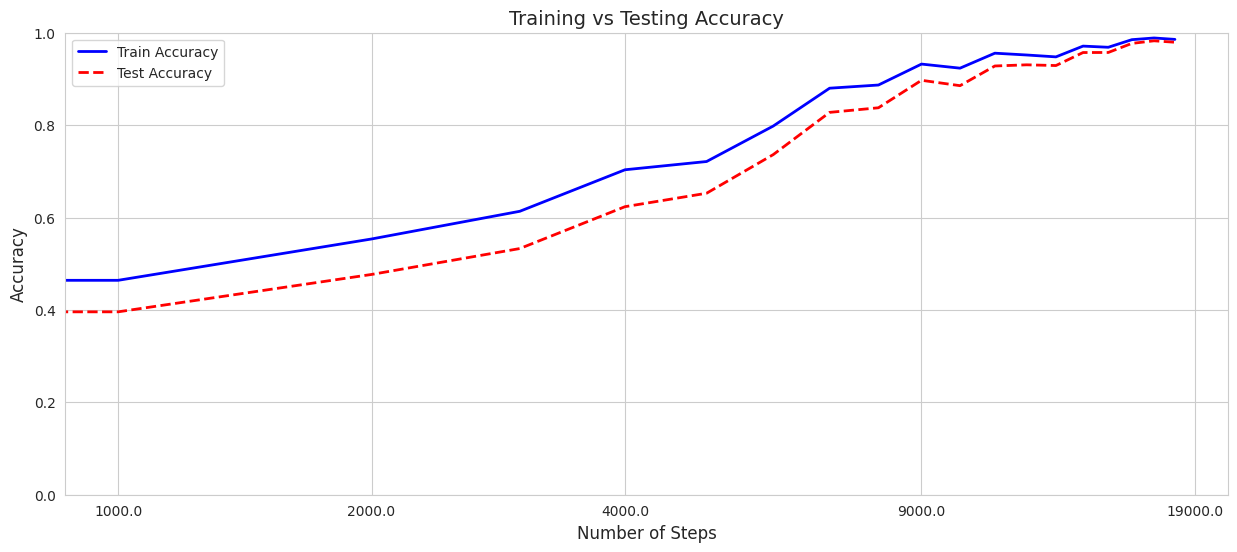

  0%|          | 199/50000 [07:11<29:58:11,  2.17s/it]


In [46]:
model = TransformerModel(ntoken = ntokens,
                         ninp = 128,
                         nhead = 4,
                         nhid = 128*4,
                         nlayers = 2,
                         dropout=0)
model.to(device)

remove_dropout(model)

train()

## <span style="color:red">Exp. 8</span> 

- 3 digits (numbers contain only three digits)
- Data sampling
- Number-level tokenizer
- dataset_size = 61440

In [60]:
number_bits = 3

dataset_size = 6144 * 10 # 6144 * 10 #5632

tokenizer = number_level_tokenizer()
ntokens = tokenizer.ntokens

print(ntokens)

data = []
for _ in range(dataset_size):
    data.append(sample_datapoint(number_bits, remove_first_zero = False))
data[:4]


data_train = data[: int(train_proportion * dataset_size)]
data_test = data[int(train_proportion * dataset_size):]

1004


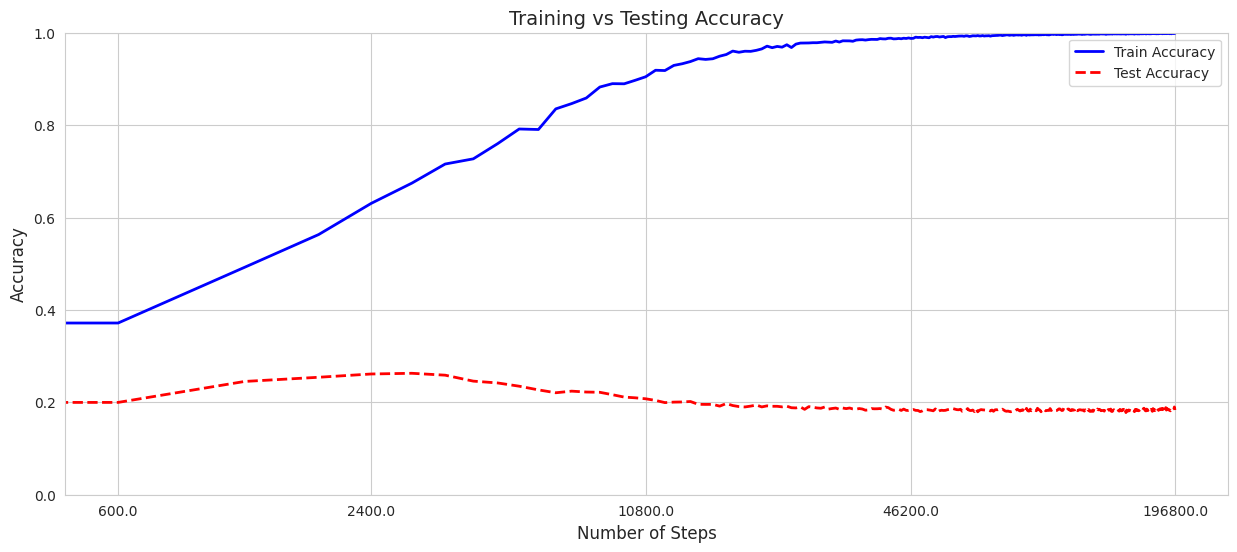

  7%|▋         | 3280/50000 [1:14:11<17:36:52,  1.36s/it]

In [ ]:
model = TransformerModel(ntoken = ntokens,
                         ninp = 128,
                         nhead = 4,
                         nhid = 128*4,
                         nlayers = 2,
                         dropout=0)
model.to(device)

remove_dropout(model)

train(early_stopping = 200000)

## Conclusion: 

Achieving grokking is very difficult. Success depends on many factors, including the correct tokenizer, the number of tokens, and the sample size. We were able to replicate similar results to the paper in the case of adding two-digit numbers. In the case of three-digit numbers, either the test set quality is highly correlated with the training set, or it doesn’t change throughout the 20,000 gradient steps.

Based on our observations, to achieve grokking in the addition task, the dataset size should be approximately 10^{$\text{number\_bits}$} * 10^{$\text{number\_bits}$}, meaning the dataset size should roughly equal the number of all possible (X, Y) pairs.

For number_bits = 2: data size ~ 10,000

For number_bits = 3: data size ~ 1,000,000

The convergence of train accuracy for two-digit numbers happens in far fewer steps. It would be reasonable to assume that potential grokking would occur at much later iterations